# Demo of Blip2 Quantization, Inference, and Scoring

## 1. Load Model and Quantize

In [1]:
from blip_quantizer import BlipQuantizer, QuantConfig, ModelPart, LayerGroup, LayerType
from quant_functions import uniform_quantization
import torch
from transformers import Blip2Processor, Blip2ForConditionalGeneration, AutoTokenizer
from datasets import VQAv2Eval
from tqdm import tqdm
from PIL import Image
from torch.utils.data import DataLoader
from utils import print_model_structure
from lavis.models import load_model_and_preprocess

In [2]:
vqav2_dataset = VQAv2Eval(
    image_root="./data/vqav2/val2014",
    ann_root="./data/vqav2/annotations",
    q_root="./data/vqav2/questions"
)

In [3]:
model, vis_processors, _ = load_model_and_preprocess("blip2_t5", "pretrain_flant5xl", device="cuda", is_eval=True)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-opt-2.7b")
model = model.to(device)

quantizer = BlipQuantizer(model)
configs = [
    QuantConfig(ModelPart.VIT, LayerGroup.FIRST, LayerType.BOTH, 
                uniform_quantization, num_bits=8),
    QuantConfig(ModelPart.VIT, LayerGroup.MIDDLE, LayerType.MLP, 
                uniform_quantization, num_bits=8),
    QuantConfig(ModelPart.QFORMER, LayerGroup.MIDDLE, LayerType.MLP, 
                uniform_quantization, num_bits=4),
]


print("Quantizing model...")
#quantizer.apply_quantization(configs)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Quantizing model...


In [5]:
from inference_pipeline import InferencePipeline

processor = Blip2Processor.from_pretrained("Salesforce/blip2-opt-2.7b", padding_side="left")

processor_kwargs={"padding": "longest", "max_length": 32, "truncation": True}
generate_kwargs={"num_beams": 5, "max_new_tokens": 10, "min_length": 1, "length_penalty": 0, "do_sample": False}

inferencer = InferencePipeline(model, device, processor)
print("Starting inference...")
results = inferencer.run_inference(
    vqav2_dataset, 
    task="visual_question_answering", 
    max_samples=10, 
    processor_kwargs=processor_kwargs, 
    generate_kwargs=generate_kwargs
)
print("Inference Finished, Saving Results...")
inferencer.save_results(results, "./results/vqav2_quantized_inference.json")

Starting inference...


100%|██████████| 10/10 [00:03<00:00,  2.69it/s]

Inference Finished, Saving Results...


## 3. Score Results from .json File

In [6]:
from scoring_pipeline import ScoringPipeline

scorer = ScoringPipeline()
loaded_results = scorer.load_results("./results/vqav2_quantized_inference.json")

loaded_results["annotations"] = "./data/vqav2/annotations/v2_mscoco_val2014_annotations.json"
loaded_results["questions"] = "./data/vqav2/questions/v2_OpenEnded_mscoco_val2014_questions.json"

scores = scorer.compute_scores(loaded_results, task="visual_question_answering")

for metric, score in scores.items():
    print(f"{metric}: {score}")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Adding current path to python system paths
loading VQA annotations and questions into memory...
0:00:06.386413
creating index...
index created!
Loading and preparing results...     
DONE (t=0.00s)
creating index...
index created!
computing accuracy
Finshed Percent: [--------------------] 0% Done computing accuracy
agg_metrics: 23.0
other: 18.57
yes/no: 50.0
number: 0.0


## Sample Results

This is not a necessary step but just helps qualitatively understand how the results relate to the answers.

In [7]:
import json
import matplotlib.pyplot as plt
import re

f = open("./results/vqav2_quantized_inference.json")

data = json.load(f)
f.close()

def show_results(idx, results, vqav2_dataset):
    pair = vqav2_dataset.qa_pairs[idx]
    image = Image.open(vqav2_dataset.image_root+'/'+pair["image"]).convert("RGB")
    plt.figure()
    plt.imshow(image)
    plt.show()
    print(pair['question'])
    print(f"true answers: {pair['answer']}")

    pred_ans = []
    for qa in results["answers"]:
        if qa["question_id"] == pair["question_id"]:
            pred_ans.append(qa["answer"].strip())
                            
    print(f"pred answers: {pred_ans}")

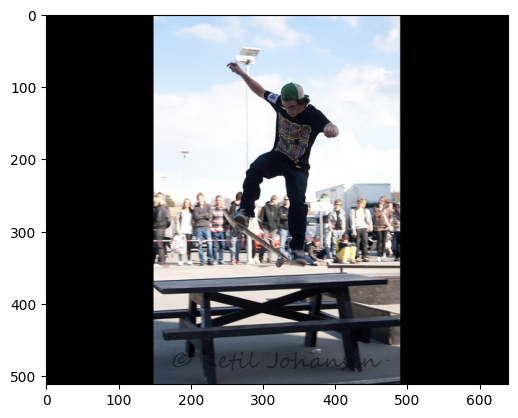

What are the people in the background doing?
true answers: ['spectating', 'watching', 'watching', 'watching', 'watching', 'watching', 'watching', 'watching', 'watching', 'watching']
pred answers: ['nothing']


In [8]:
show_results(1, data, vqav2_dataset)

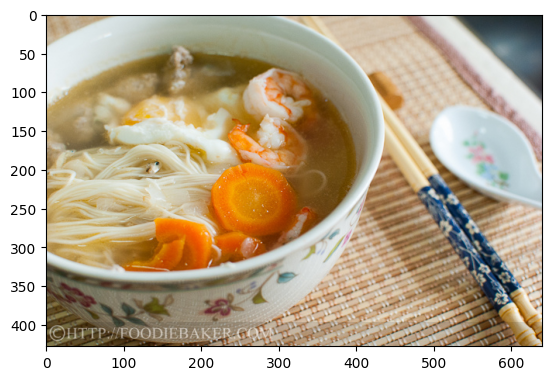

What website copyrighted the picture?
true answers: ['foodiebakercom', 'foodiebakercom', 'foodiebaker', 'foodiebakercom', 'foodiebakercom', 'http://foodiebakercom', 'foodiebakercom', 'foodiebakercom', 'foodiebakercom', 'foodiebaker']
pred answers: ['none']


In [9]:
show_results(3, data, vqav2_dataset)

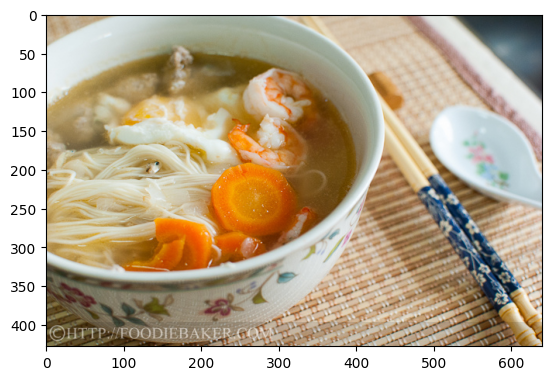

Is this rice noodle soup?
true answers: ['yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes']
pred answers: ['yes']


In [10]:
show_results(5, data, vqav2_dataset)

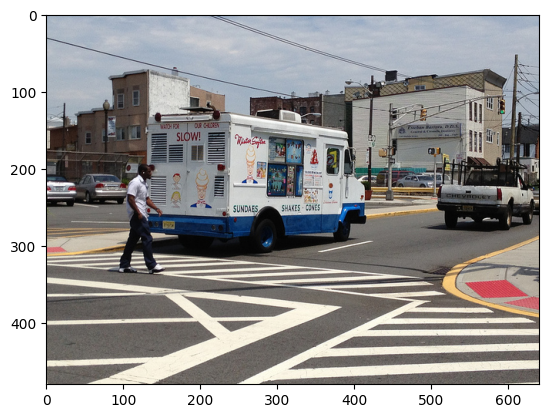

What is the man doing in the street?
true answers: ['crossing it', 'walking', 'walking', 'crossing', 'crossing road', 'walking', 'crossing', 'walking', 'crossing', 'walking']
pred answers: ['crossing the street']


In [11]:
show_results(7, data, vqav2_dataset)

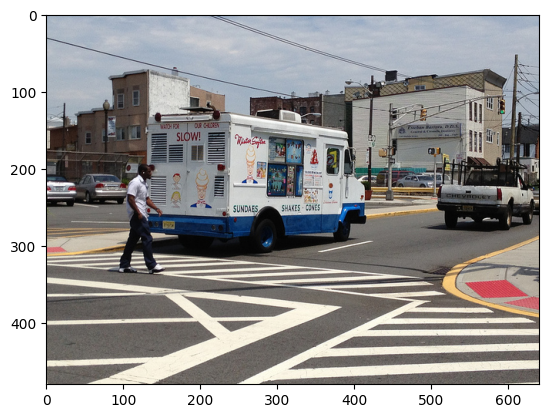

What does the truck on the left sell?
true answers: ['ice cream', 'ice cream', 'ice cream', 'ice cream', 'ice cream', 'ice cream', 'ice cream', 'ice cream', 'ice cream', 'ice cream']
pred answers: ['ice cream']


In [12]:
show_results(9, data, vqav2_dataset)